In [1]:
import seaborn as sns
import pandas  as pd
import numpy   as np
from matplotlib import pyplot as plt
from os         import listdir
sns.set_theme()
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Load Data

In [2]:
def find_files(path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [3]:
def data_extraction(path, datos):
    data = []
    for file in datos:
        df_temp               = pd.read_csv(path + file)
        df_temp['Cliente']    = file[:-4]
        df_temp['id_Cliente'] = int(''.join([s for s in file if s.isdigit()]))
        df_temp['Fecha'] = pd.to_datetime(df_temp['Fecha'])
        # Luego, si quieres extraer solo la fecha sin la hora, puedes hacerlo así
        df_temp['Fecha'] = df_temp['Fecha'].dt.date
        #df_temp               = df_temp.set_index('Fecha')
        #df_temp               = df_temp.asfreq('H')
        data.append(df_temp)
    return pd.concat(data)

In [4]:
def data_sector(path, datos):
    df_temp = pd.read_excel(path+datos[0])
    df_temp['id_Cliente'] = df_temp['Cliente:'].str.extract('(\d+)').astype('int')
    return df_temp

In [5]:
path = './'
#find_files(path)

## Datos de Consumo del Cliente

In [6]:
datos_clientes_consumo = find_files(path)
df_consumo = data_extraction(path, datos_clientes_consumo)
#df_consumo.head()

In [7]:
# Agrupa por 'Cliente', 'id_Cliente', y luego resample por día y suma los valores
df_consumo = df_consumo.groupby(['Cliente', 'id_Cliente', 'Fecha']).sum().reset_index()

In [8]:
#!pip install holidays
import holidays
# Extraer componentes
df_consumo['Fecha'] = pd.to_datetime(df_consumo['Fecha'])
df_consumo['Dia'] = df_consumo['Fecha'].dt.day
df_consumo['Mes'] = df_consumo['Fecha'].dt.month
df_consumo['Año'] = df_consumo['Fecha'].dt.year
df_consumo['Trimestre'] = df_consumo['Fecha'].dt.quarter
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_consumo['Dia_semana'] = [dias_semana[i] for i in df_consumo['Fecha'].dt.weekday]
#df_consumo['Semana_año'] = df_consumo['Fecha'].dt.isocalendar().week
#df_consumo['Dia_año'] = df_consumo['Fecha'].dt.dayofyear
peru_holidays = holidays.Peru(years=df_consumo['Año'].unique().tolist())
df_consumo['Es_festivo'] = df_consumo['Fecha'].isin(peru_holidays).astype(int)
#df_consumo

In [9]:
#import pandas as pd
#df_consumo.to_csv('df_consumo.csv', index=False)

## Datos de Sector del Cliente

In [10]:
#datos_clientes_sector = find_files(path, '.xlsx')
#df_sector = data_sector(path, datos_clientes_sector)
#df_sector.head()
df_sector = pd.read_excel('sector_economico_clientes.xlsx')
df_sector  = df_sector.drop(['Sector'], axis=1)
df_sector = df_sector.rename(columns={'Sector1': 'Sector'})
df_sector = df_sector.rename(columns={'Cliente': 'id_Cliente'})

# Unión

In [11]:
df_consumo = df_consumo.reset_index().merge(df_sector, how='left', on='id_Cliente')
df_consumo  = df_consumo.drop(['Cliente'], axis=1)
df_consumo  = df_consumo.drop(['index'], axis=1)

## StandardScaler

In [12]:
from sklearn.preprocessing import StandardScaler
def estandarizar_columnas(df, columnas_a_estandarizar):
    df_estandarizado = df.copy()
    for cliente in df['id_Cliente'].unique():
        scaler = StandardScaler()
        # Seleccionar las filas donde 'id_Cliente' es igual a 'cliente' y las columnas a estandarizar
        # Luego, aplicar el escalado y asignar los valores directamente en el DataFrame 'df_estandarizado'
        df_estandarizado.loc[df['id_Cliente'] == cliente, columnas_a_estandarizar] = scaler.fit_transform(df.loc[df['id_Cliente'] == cliente, columnas_a_estandarizar])
    return df_estandarizado

# Uso de la función:
columnas_para_estandarizar = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']  # Reemplaza con los nombres de tus columnas
df = estandarizar_columnas(df_consumo, columnas_para_estandarizar)

In [13]:
 #[df_consumo['id_Cliente']<=30]

In [14]:
df1 = pd.get_dummies(df, columns=['Dia', 'Mes', 'Año', 'Trimestre', 'Dia_semana', 'Sector'])
#df1  = df1.drop(['Dia', 'Mes', 'Año', 'Trimestre', 'Dia_semana', 'Sector'], axis=1)
df1  = df1.drop(['Fecha'], axis=1)
df1  = df1.drop(['id_Cliente'], axis=1)
df1  = df1.drop(['Voltaje_FA'], axis=1)
df1  = df1.drop(['Voltaje_FC'], axis=1)
df1  = df1.drop(['Reactive_energy'], axis=1)

In [15]:
df1.columns

Index(['Active_energy', 'Es_festivo', 'Dia_1', 'Dia_2', 'Dia_3', 'Dia_4',
       'Dia_5', 'Dia_6', 'Dia_7', 'Dia_8', 'Dia_9', 'Dia_10', 'Dia_11',
       'Dia_12', 'Dia_13', 'Dia_14', 'Dia_15', 'Dia_16', 'Dia_17', 'Dia_18',
       'Dia_19', 'Dia_20', 'Dia_21', 'Dia_22', 'Dia_23', 'Dia_24', 'Dia_25',
       'Dia_26', 'Dia_27', 'Dia_28', 'Dia_29', 'Dia_30', 'Dia_31', 'Mes_1',
       'Mes_2', 'Mes_3', 'Mes_4', 'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9',
       'Mes_10', 'Mes_11', 'Mes_12', 'Año_2021', 'Año_2022', 'Año_2023',
       'Trimestre_1', 'Trimestre_2', 'Trimestre_3', 'Trimestre_4',
       'Dia_semana_Domingo', 'Dia_semana_Jueves', 'Dia_semana_Lunes',
       'Dia_semana_Martes', 'Dia_semana_Miércoles', 'Dia_semana_Sábado',
       'Dia_semana_Viernes', 'Sector_Captacion_tratamient',
       'Sector_Cultivo_de_Hortaliza', 'Sector_Cultivo_de_arboles_F',
       'Sector_Cultivo_de_hortaliza', 'Sector_Cultivo_de_otros_fru',
       'Sector_Elaboracion_de_cacao', 'Sector_Venta_al_por_mayor

## Gráfico por sector / cliente estandarizados 

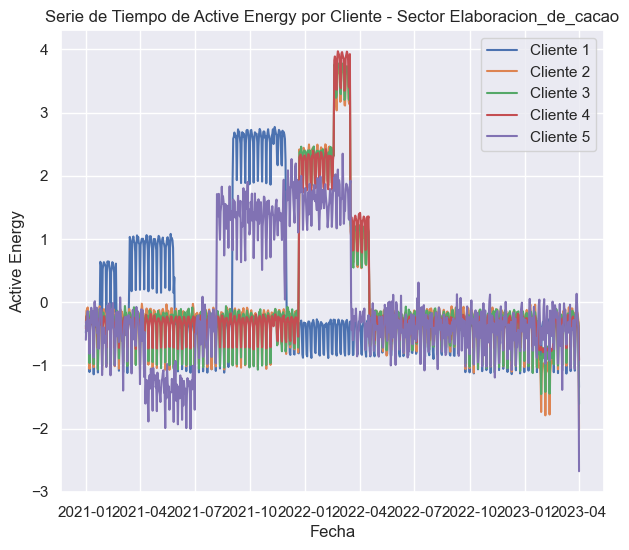

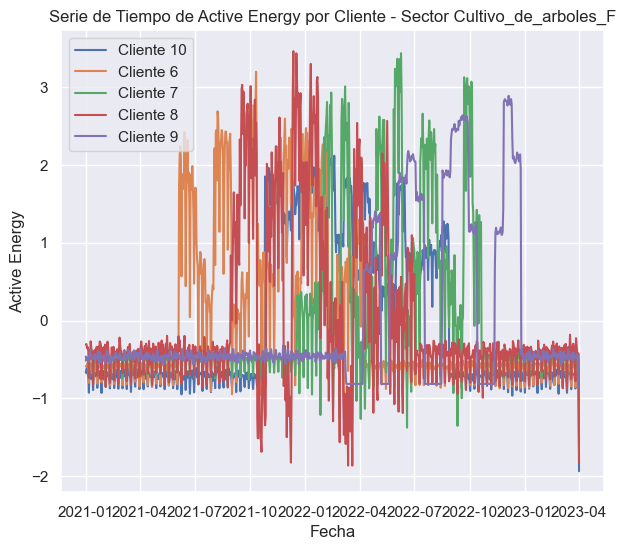

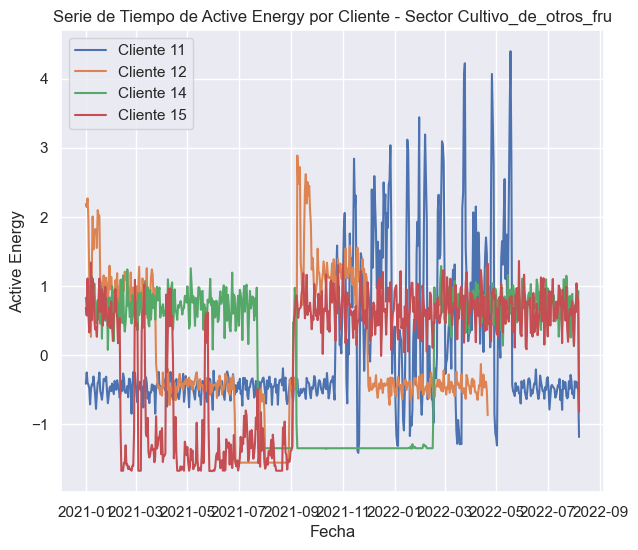

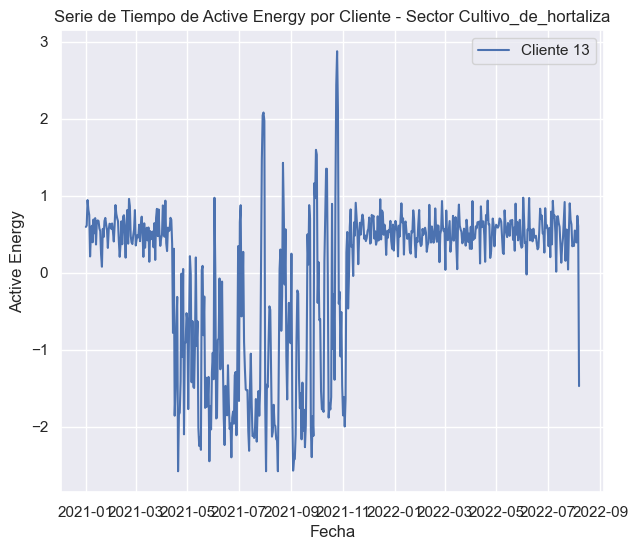

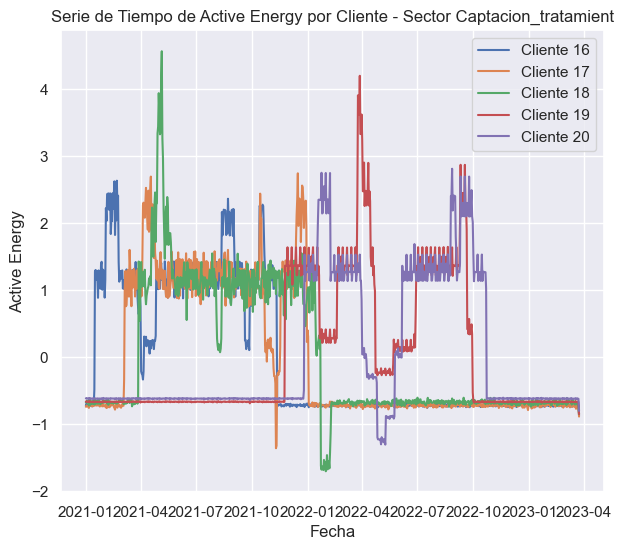

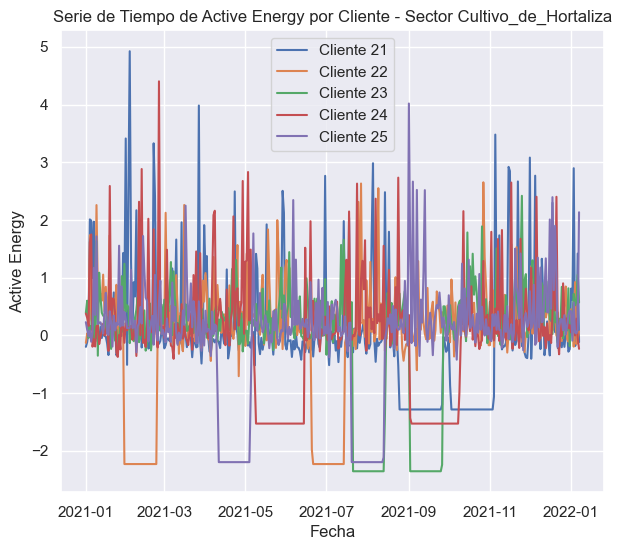

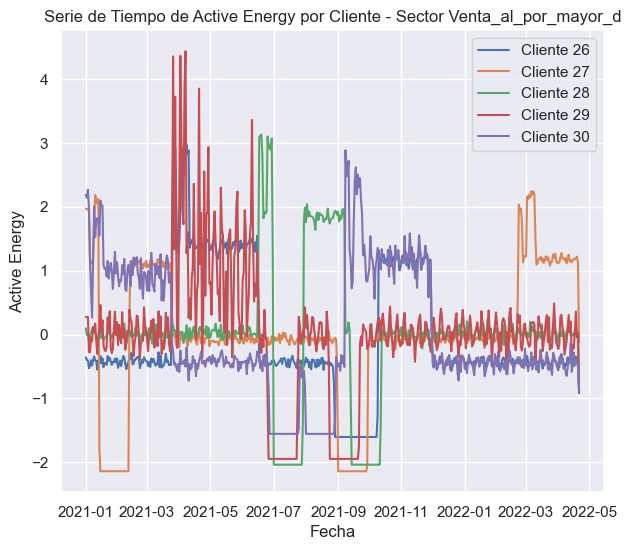

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sectores_unicos = df['Sector'].unique()

for sector in sectores_unicos:
    df_sector = df[df['Sector'] == sector]
    clientes_unicos = df_sector['id_Cliente'].unique()
    plt.figure(figsize=(7, 6))
    plt.title(f"Serie de Tiempo de Active Energy por Cliente - Sector {sector}")
    
    for cliente in clientes_unicos:
        df_cliente = df_sector[df_sector['id_Cliente'] == cliente]
        sns.lineplot(x=df_cliente['Fecha'], y=df_cliente['Active_energy'], label=f'Cliente {cliente}')
   
    plt.xlabel('Fecha')
    plt.ylabel('Active Energy')
    plt.legend()
    plt.show()


## LocalOutlierFactor

In [38]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

X = df1.values

# Crear el modelo Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=300, contamination=0.05)

# Entrenar el modelo
y_pred = lof.fit_predict(X)

# Predicción de anomalías
X_scores = lof.negative_outlier_factor_

In [18]:

# Puntuaje de anomalías
anomaly_scores = lof.negative_outlier_factor_
# Predicción de anomalías
anomalies = lof.negative_outlier_factor_ < lof.offset_
lof_offset= lof.offset_


anomalies_series= pd.Series(anomalies, name='anomalies')
anomaly_scores_series = pd.Series(anomaly_scores, name='anomaly_scores')

y_pred_series = pd.Series(y_pred, name='y_pred')
X_scores_series = pd.Series(X_scores, name='X_scores')

lof_offset_series= pd.Series(lof_offset, name='lof_offset')
# Unir las Series al DataFrame original
df_final = pd.concat([df.reset_index(), y_pred_series, X_scores_series,anomalies_series, anomaly_scores_series], axis=1)


## Gráfico por Clientes con anomalias 

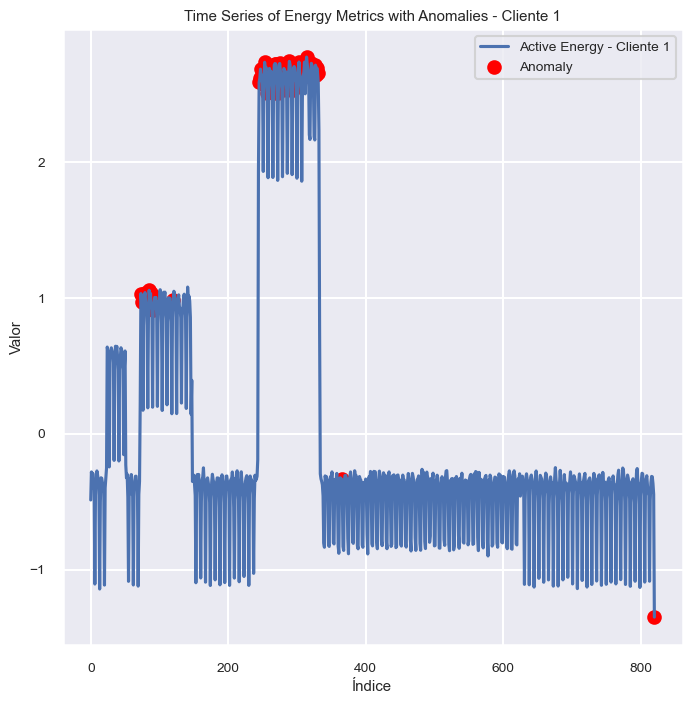

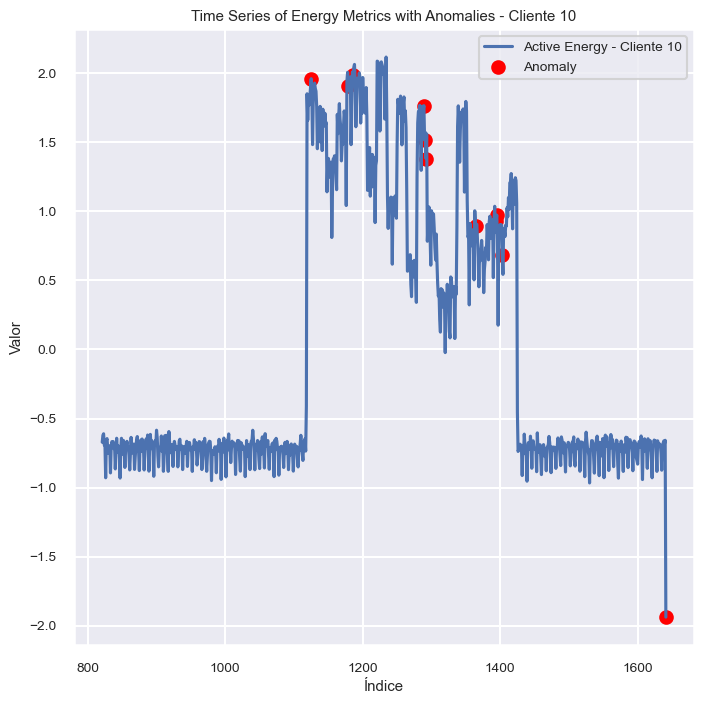

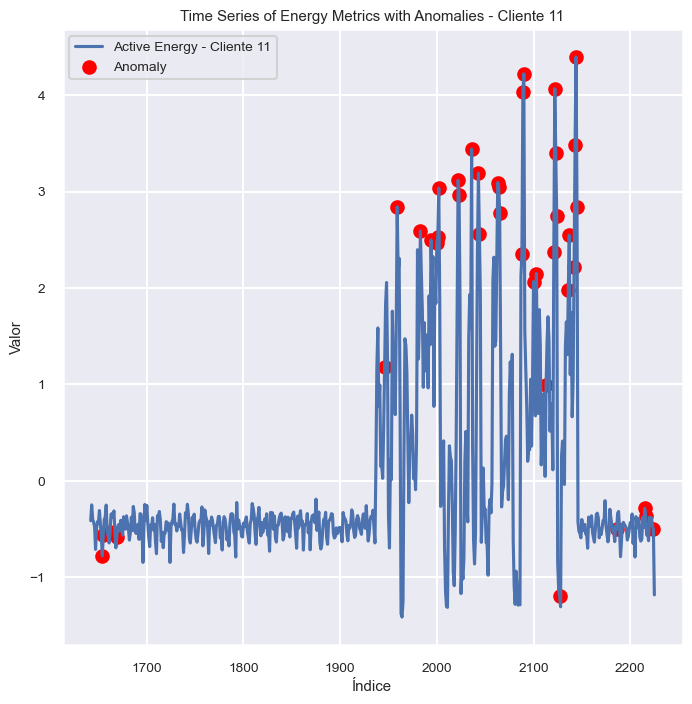

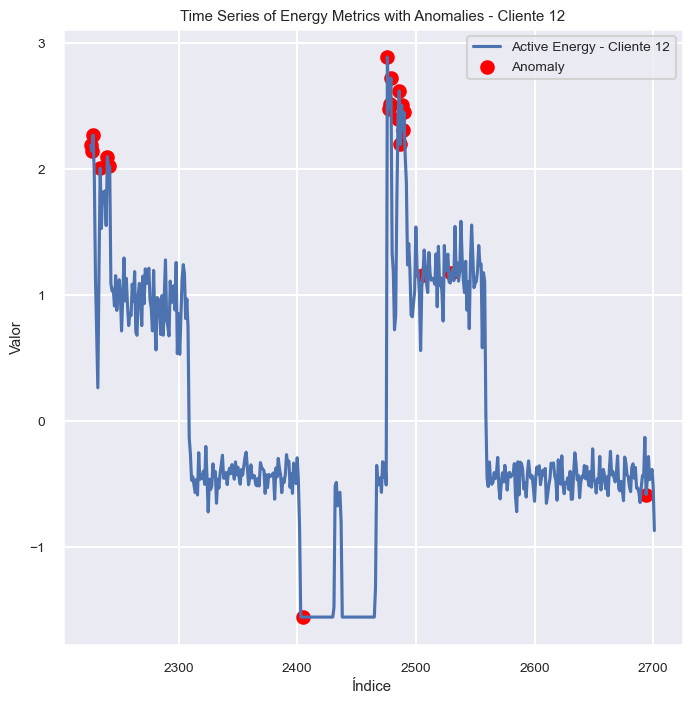

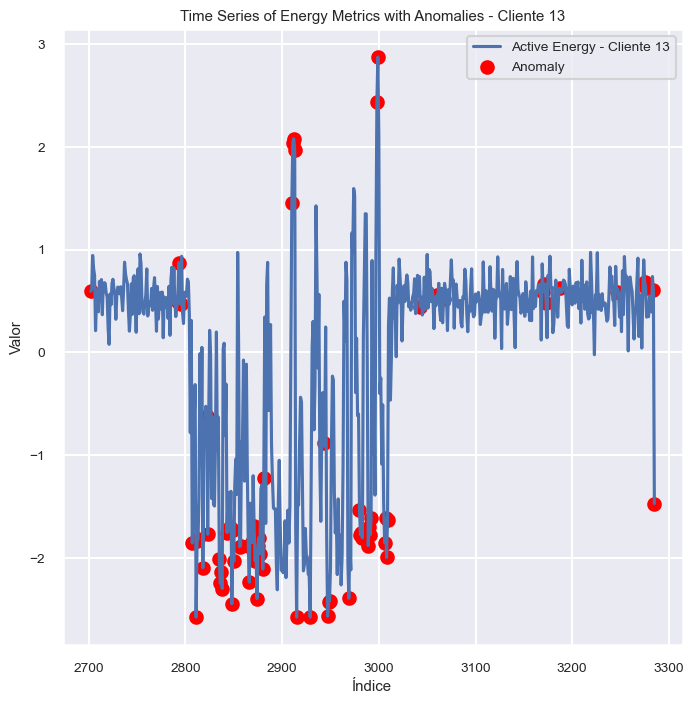

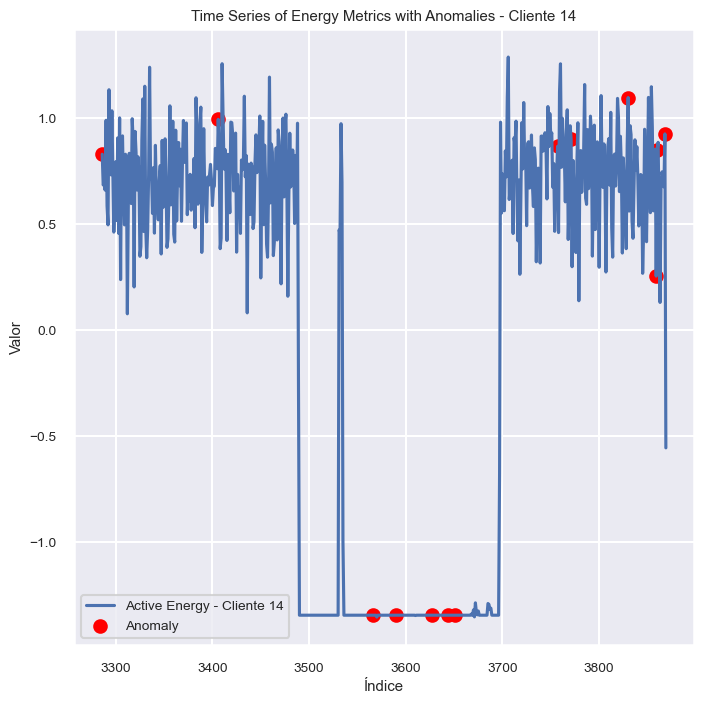

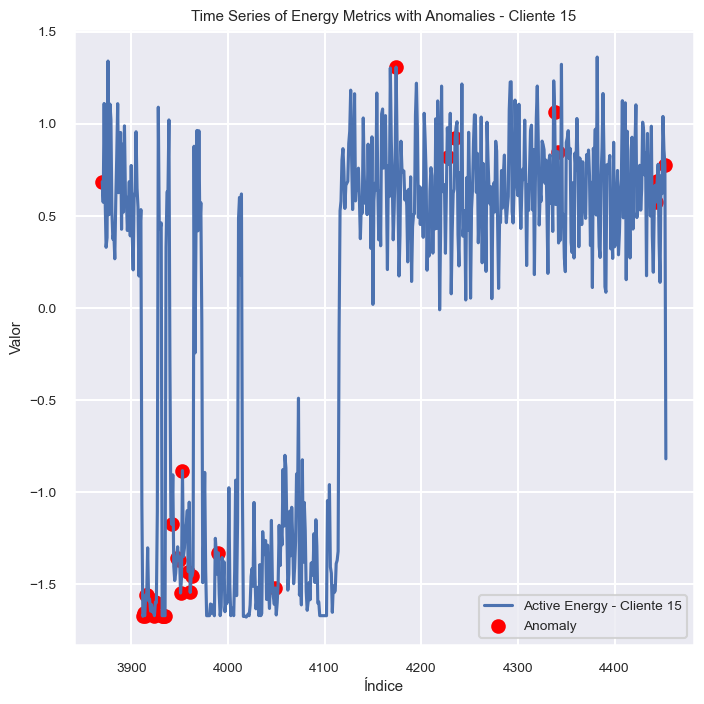

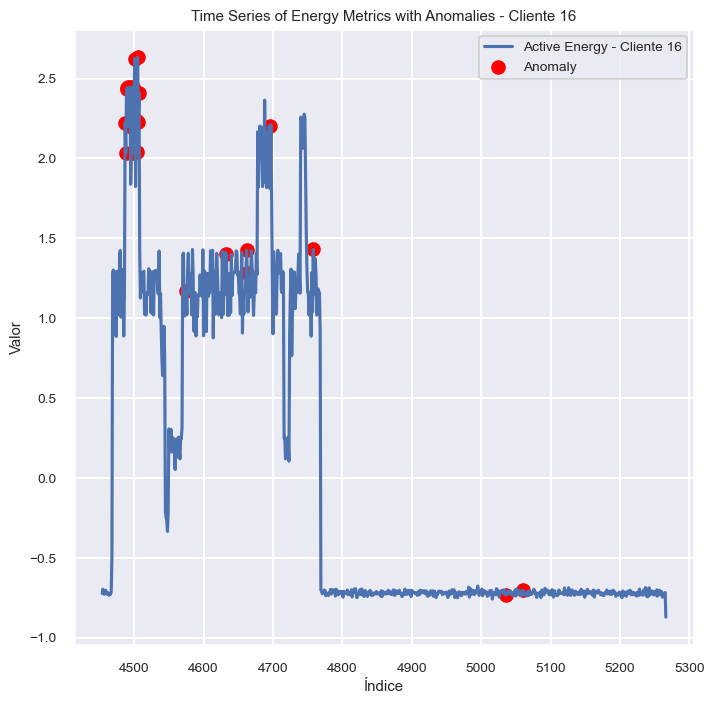

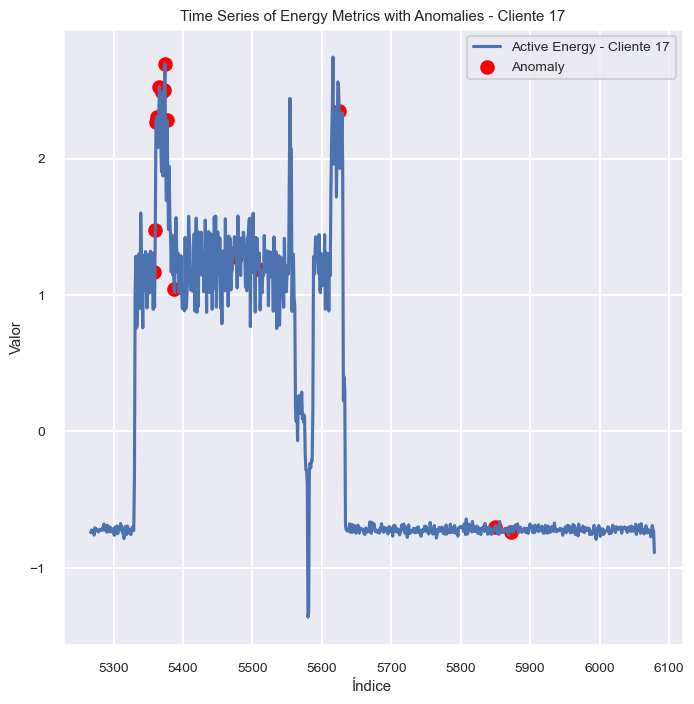

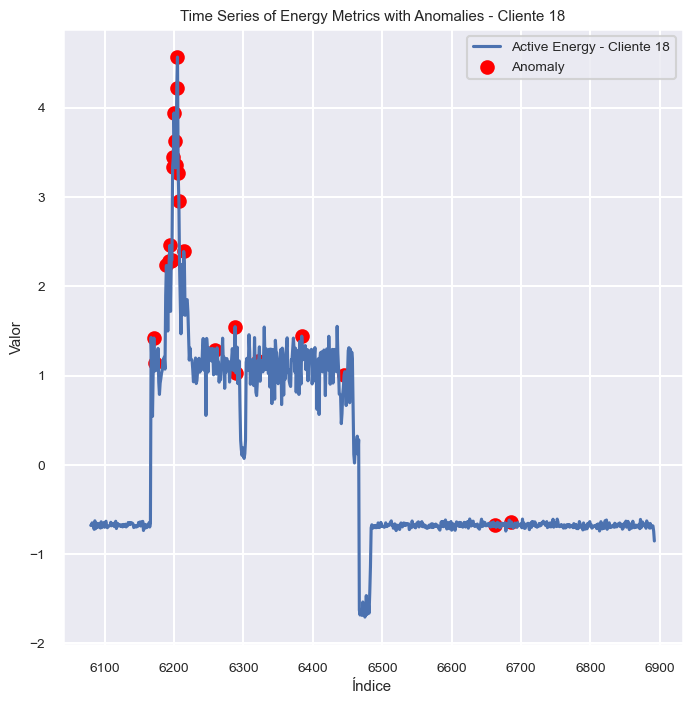

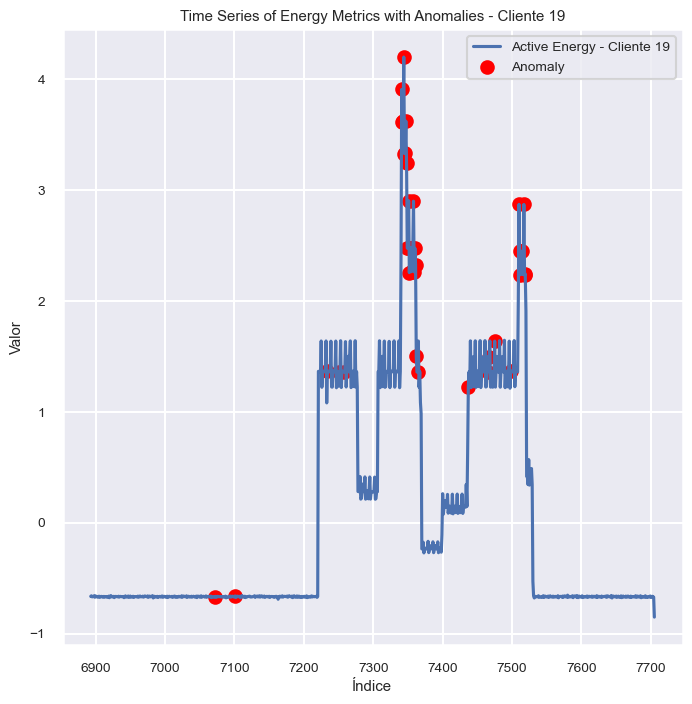

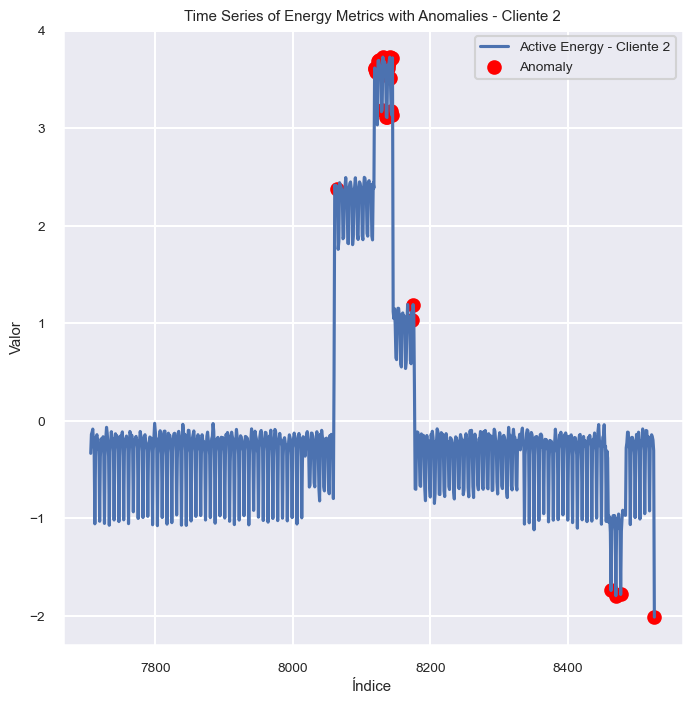

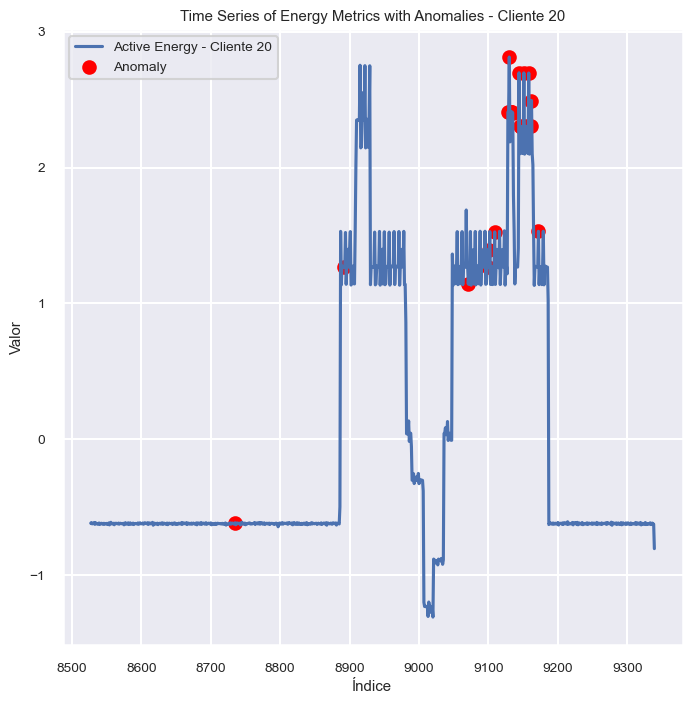

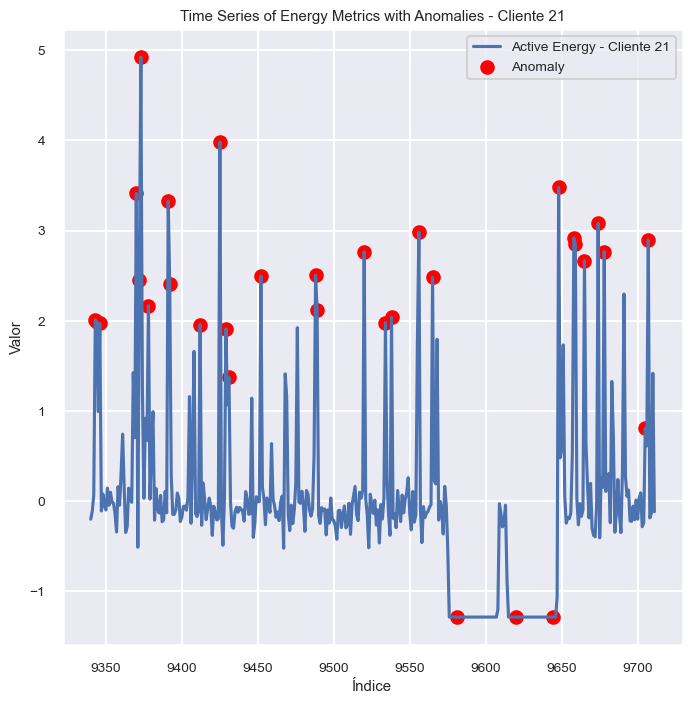

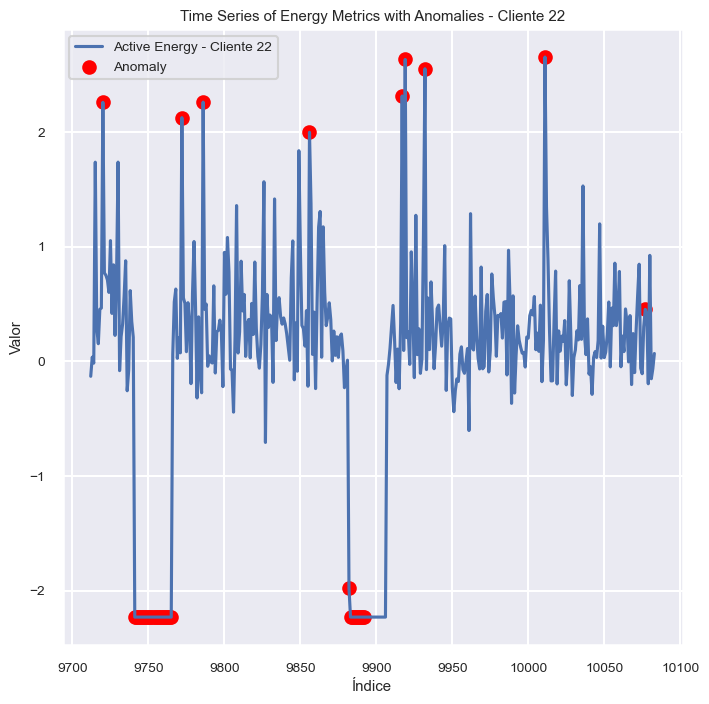

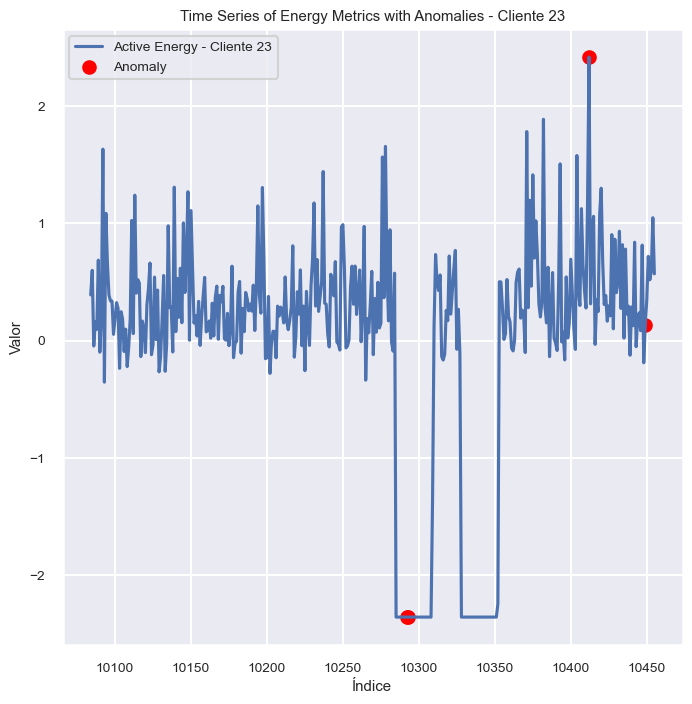

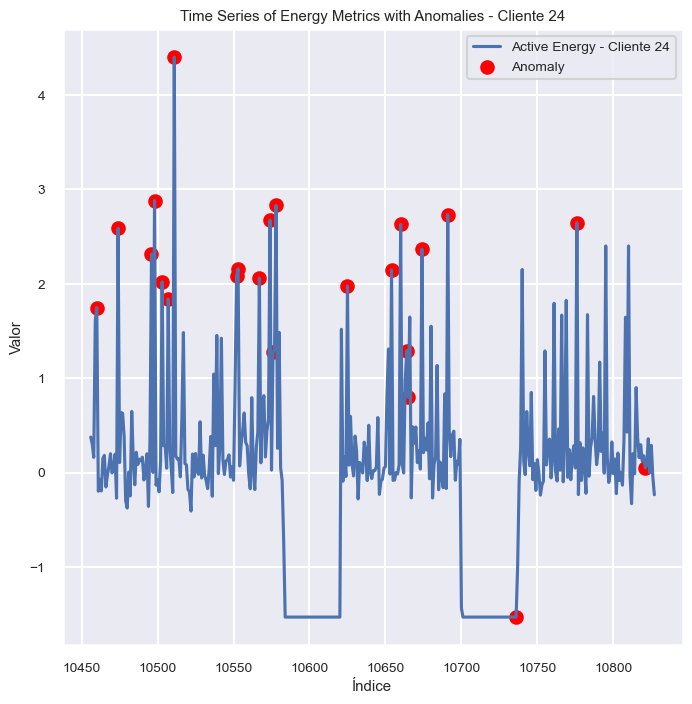

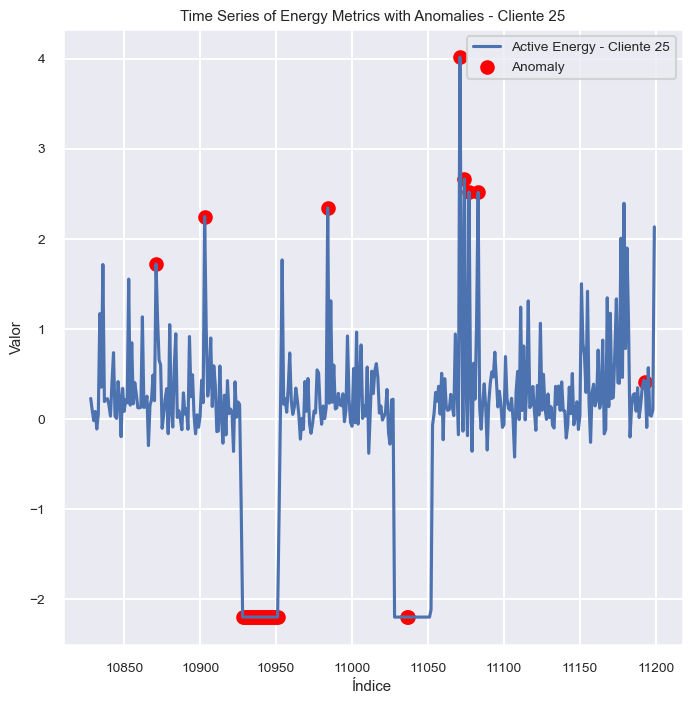

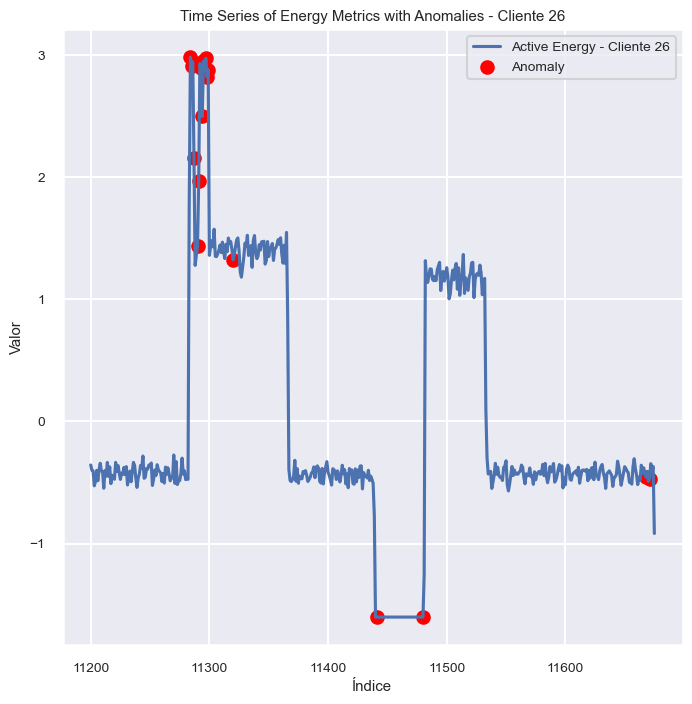

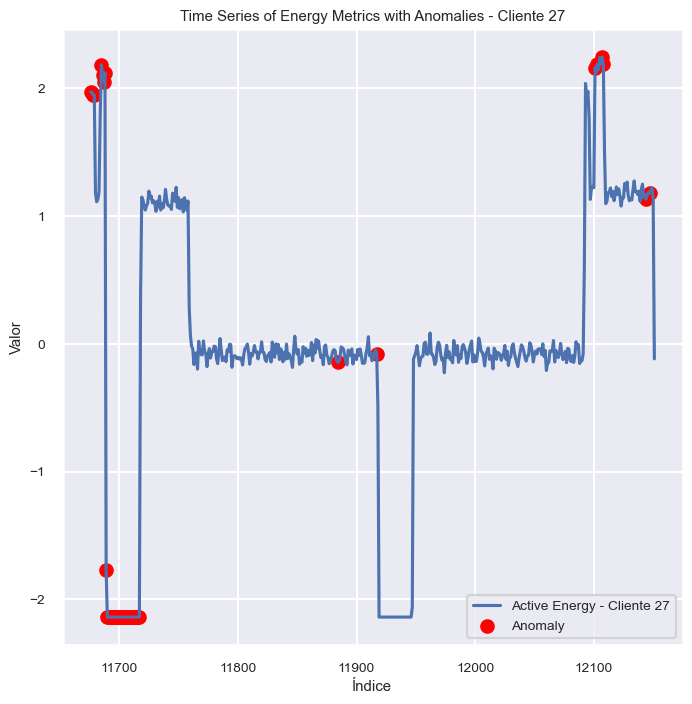

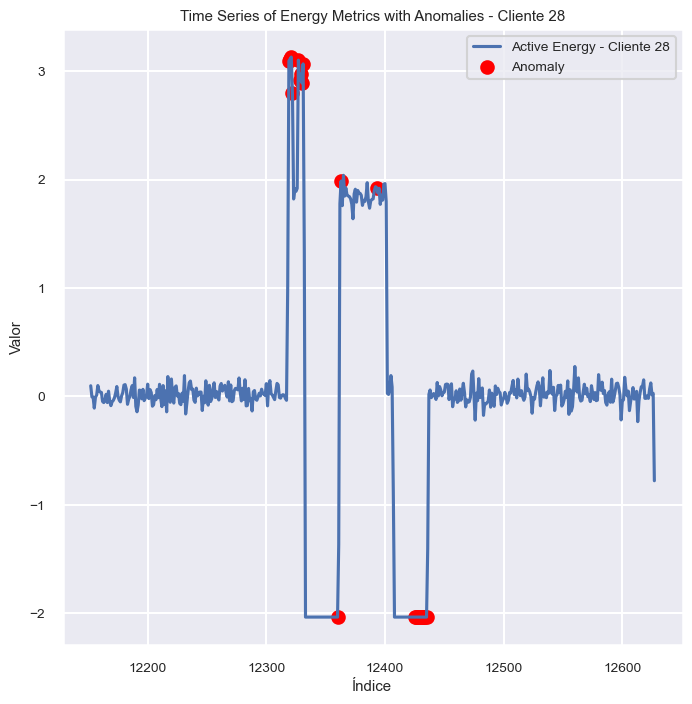

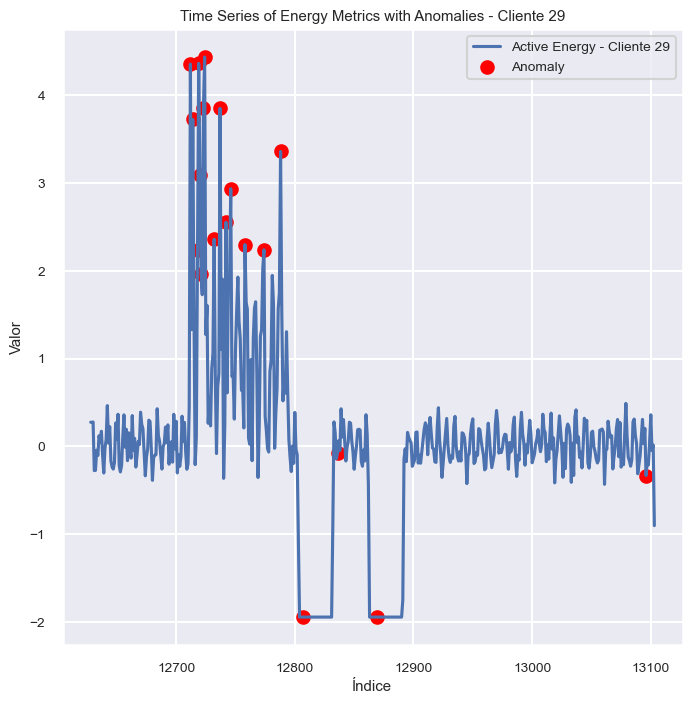

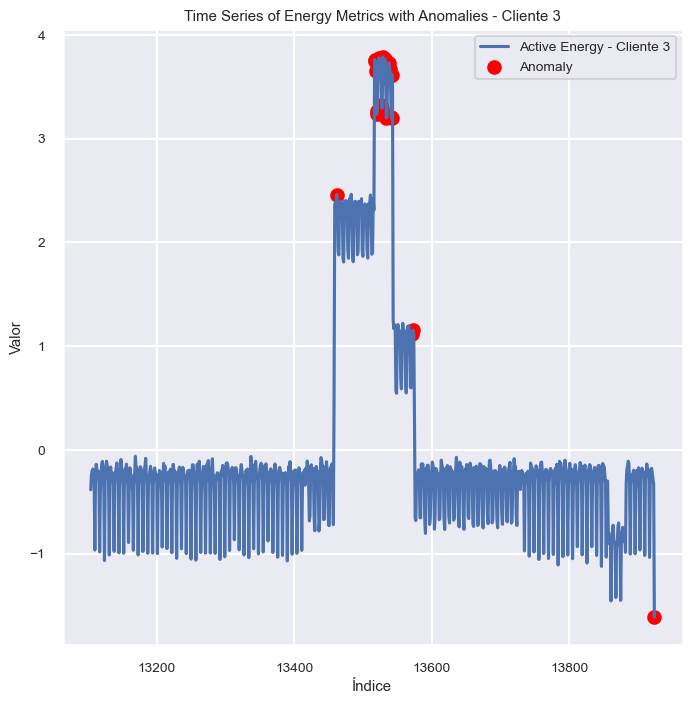

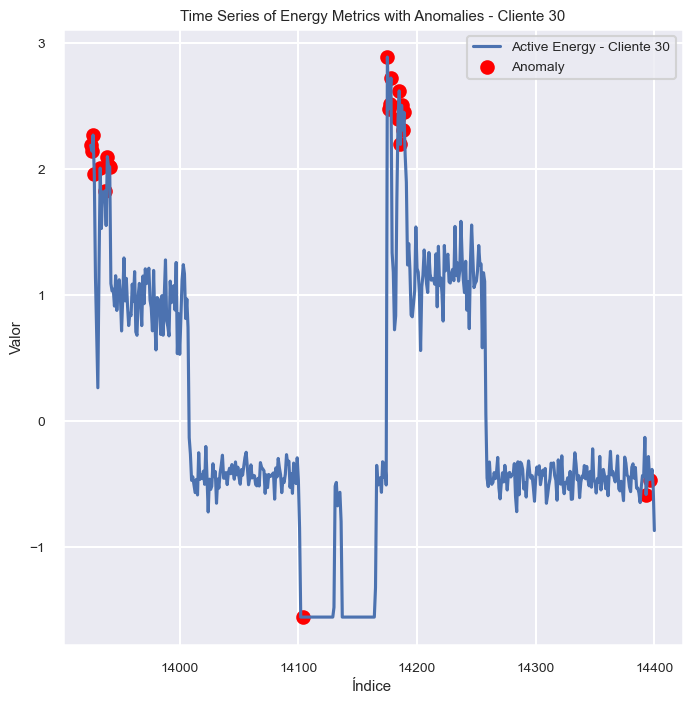

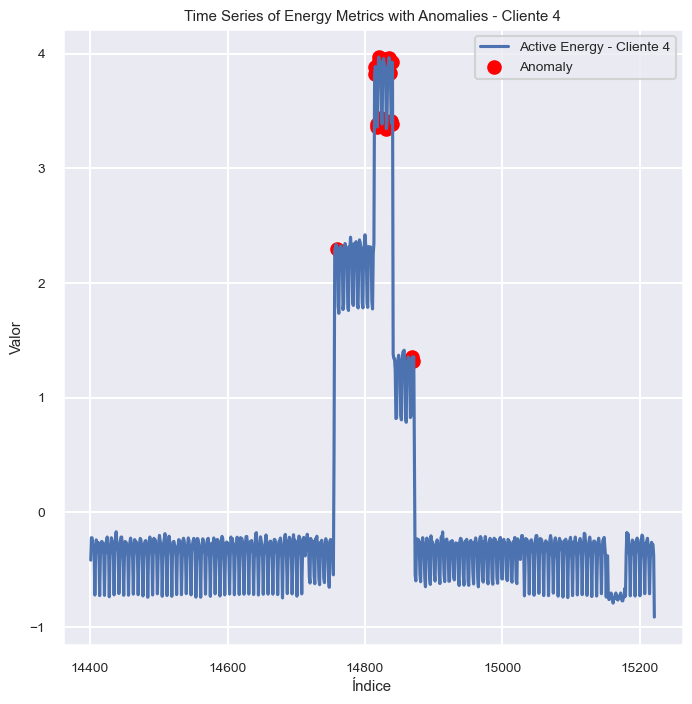

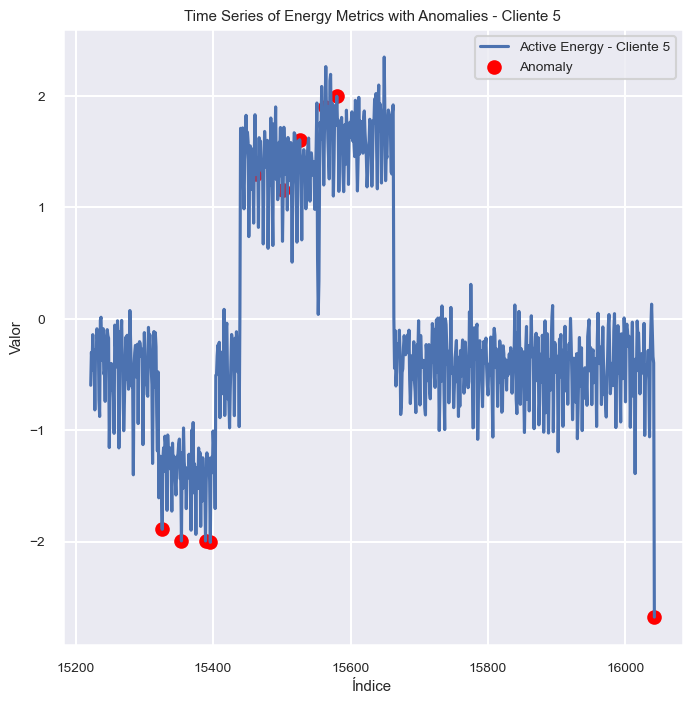

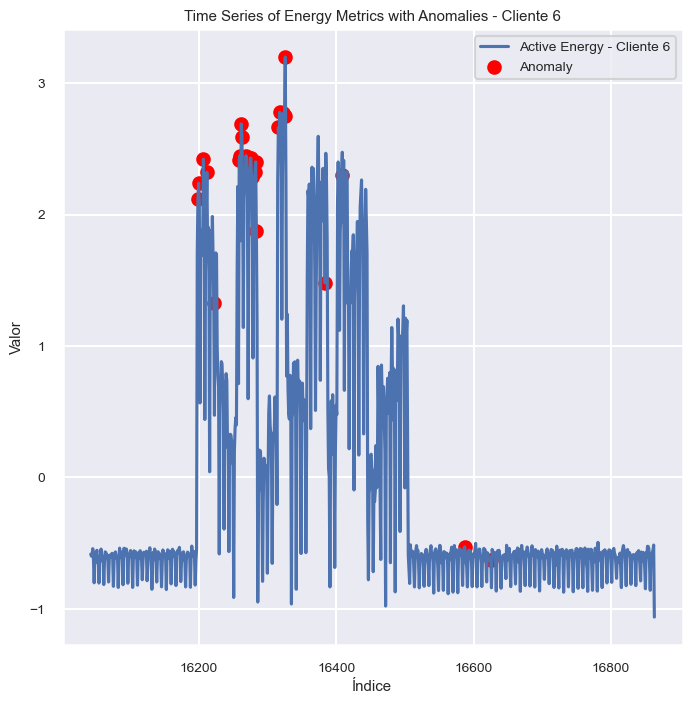

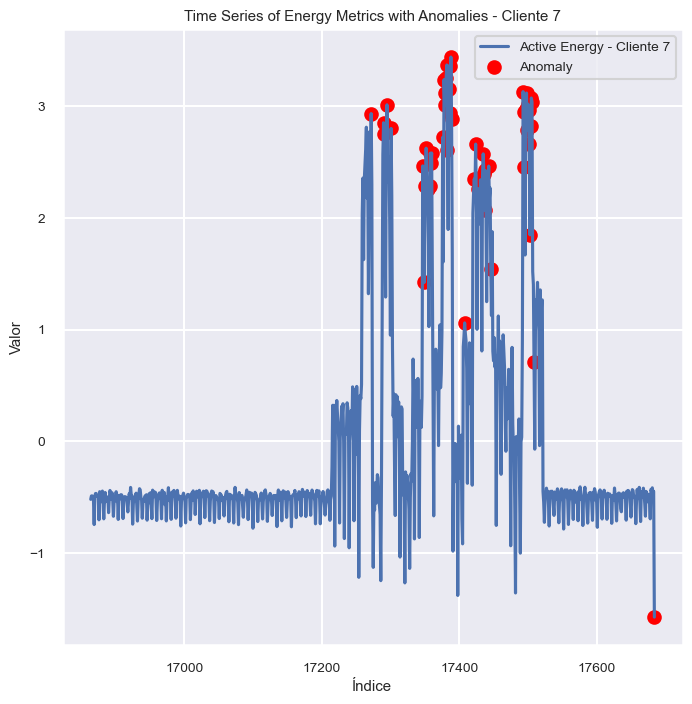

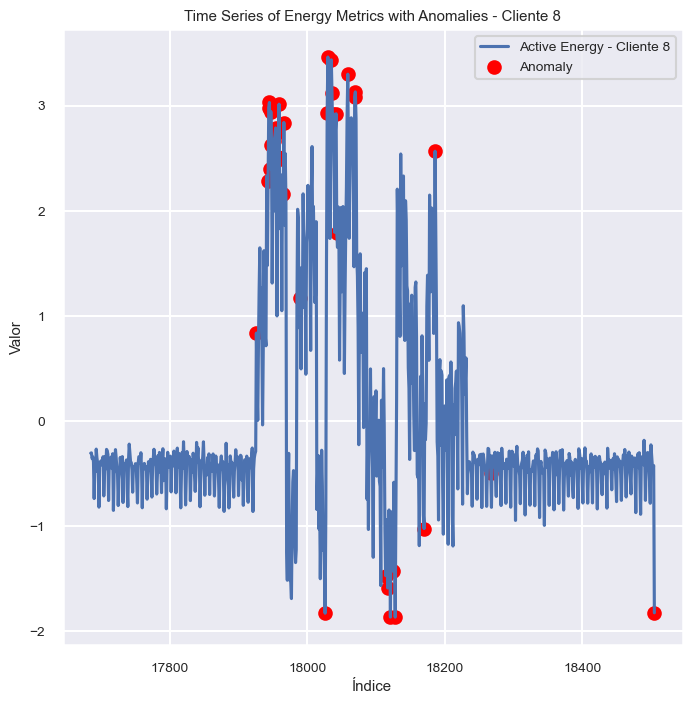

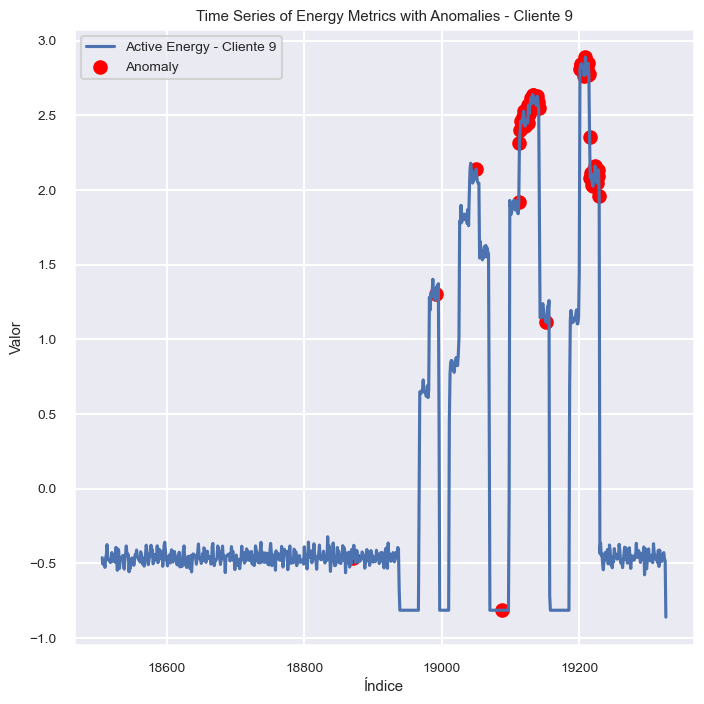

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns


# Obtener los identificadores únicos de los clientes
clientes_unicos = df_final['id_Cliente'].unique().astype(int)

# Se puede cambiar 'talk' por 'paper', 'notebook', 'talk', o 'poster'
sns.set_context('talk', font_scale=0.6)  

# Crear una figura para cada cliente
for cliente in clientes_unicos:
    
    # Filtrar el DataFrame por cliente
    df_cliente = df_final[df_final['id_Cliente'] == cliente]
    
    # Crear una figura y un eje para este cliente
    fig, ax = plt.subplots(figsize=(8, 8))
    # Graficar la serie de tiempo de cada métrica para este cliente
    #sns.lineplot(x=df_cliente.index, y='Voltaje_FA', data=df_cliente, ax=ax, label=f'Voltaje FA - Cliente {cliente}')
    #sns.lineplot(x=df_cliente.index, y='Voltaje_FC', data=df_cliente, ax=ax, label=f'Voltaje FC - Cliente {cliente}')
    #sns.lineplot(x=df_cliente.index, y='Reactive_energy', data=df_cliente, ax=ax, label=f'Reactive Energy - Cliente {cliente}')
    sns.lineplot(x=df_cliente.index, y='Active_energy', data=df_cliente, ax=ax, label=f'Active Energy - Cliente {cliente}')
   
    # Resaltar las anomalías para este cliente
    anomalies = df_cliente[df_cliente['y_pred'] == -1]
    ax.scatter(anomalies.index, anomalies['Active_energy'], color='red', label='Anomaly')
    
    # Ajustar el tamaño de los puntos de anomalía basado en 'X_scores'
    sizes = (np.abs(anomalies['X_scores'])).tolist()  # Ajusta el factor de escala según sea necesario
    for i, (index, point) in enumerate(anomalies.iterrows()):
        ax.scatter(index, point['Active_energy'], s=sizes[i], color='red')
    
    # Mejorar el gráfico para este cliente
    ax.set_title(f'Time Series of Energy Metrics with Anomalies - Cliente {cliente}')
    ax.set_xlabel('Índice')
    ax.set_ylabel('Valor')
    ax.legend()
    
    plt.savefig(f'cliente_{cliente}.png')  # Guarda la imagen

    # Mostrar el gráfico para este cliente
    plt.show()

## Gráfico por Sector y Clientes con anomalias

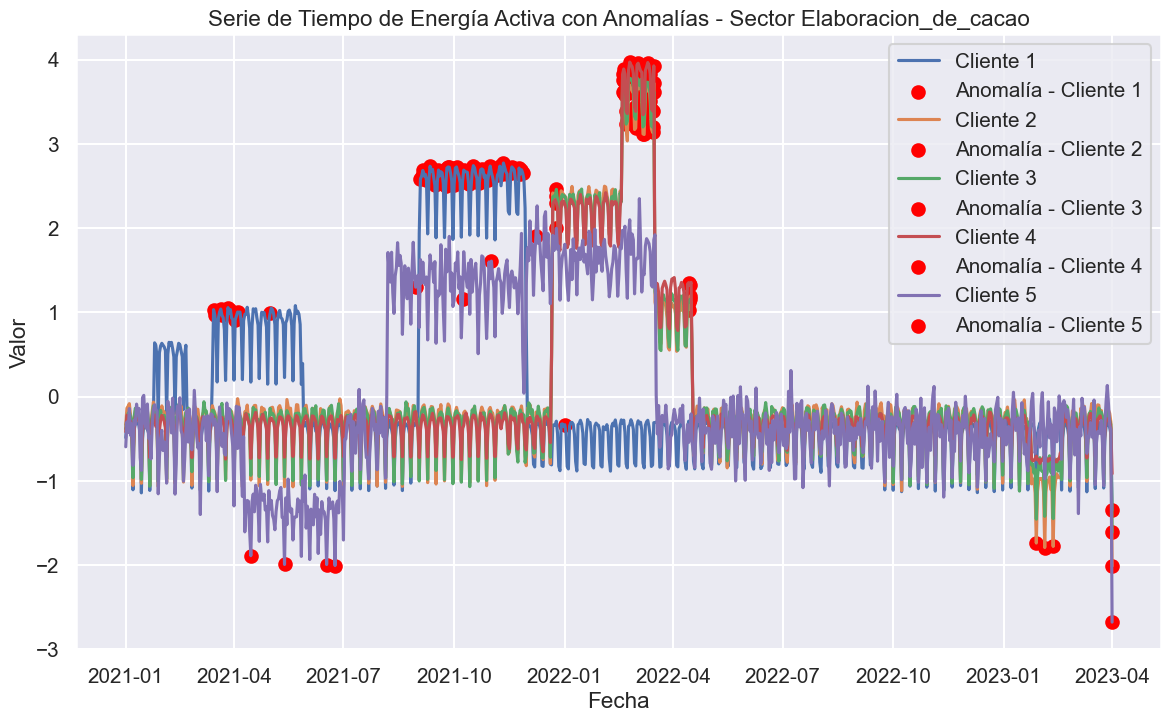

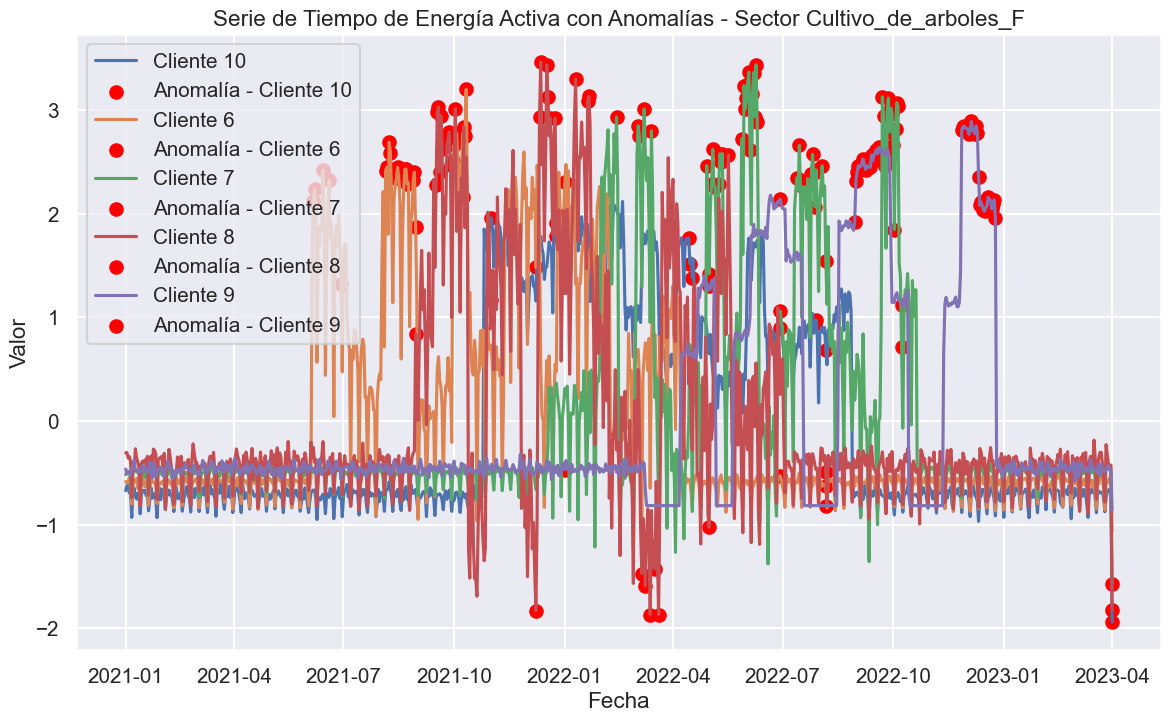

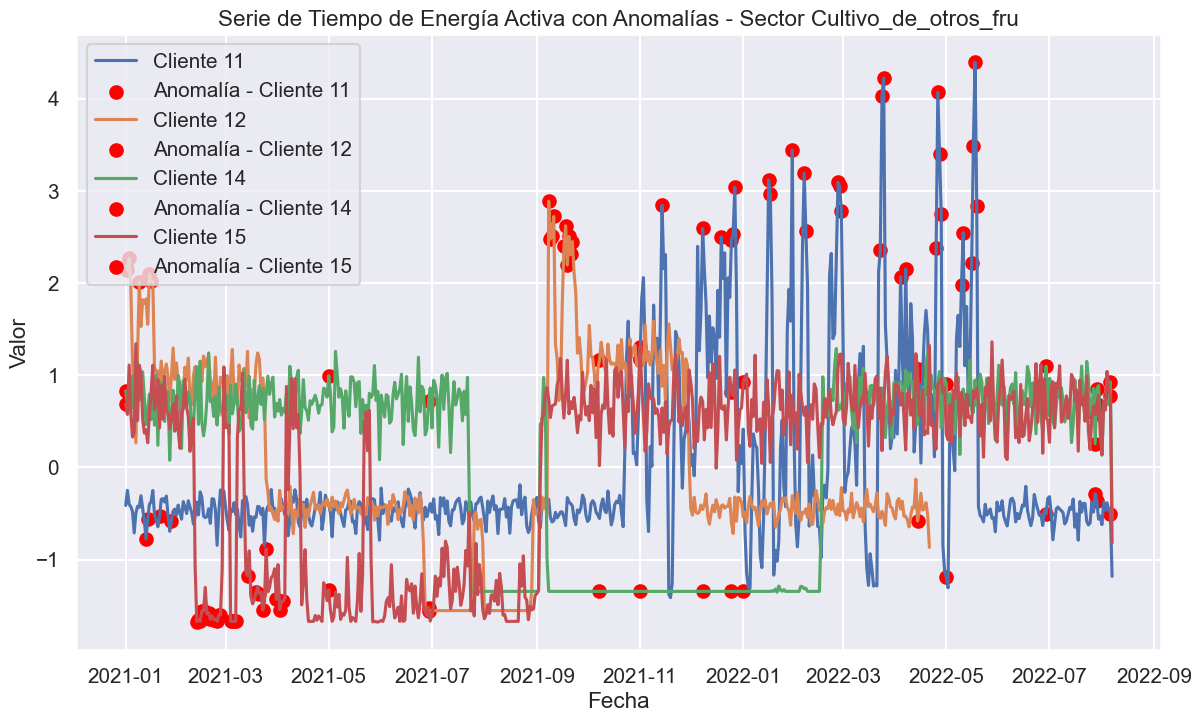

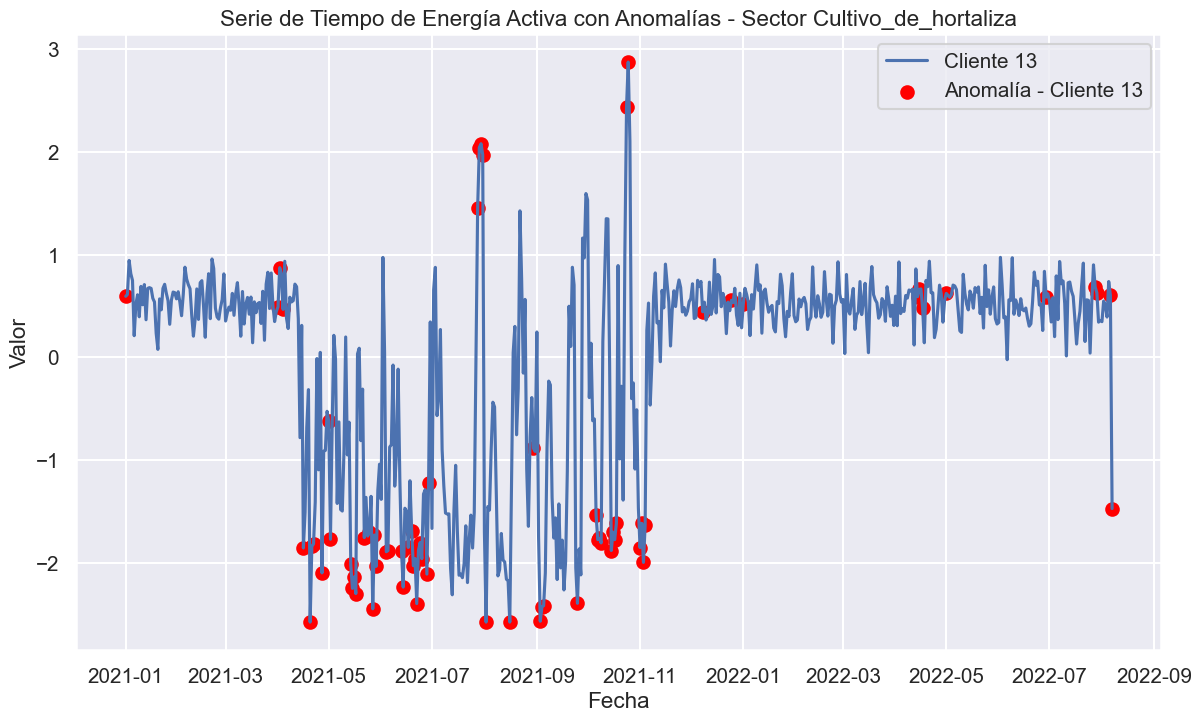

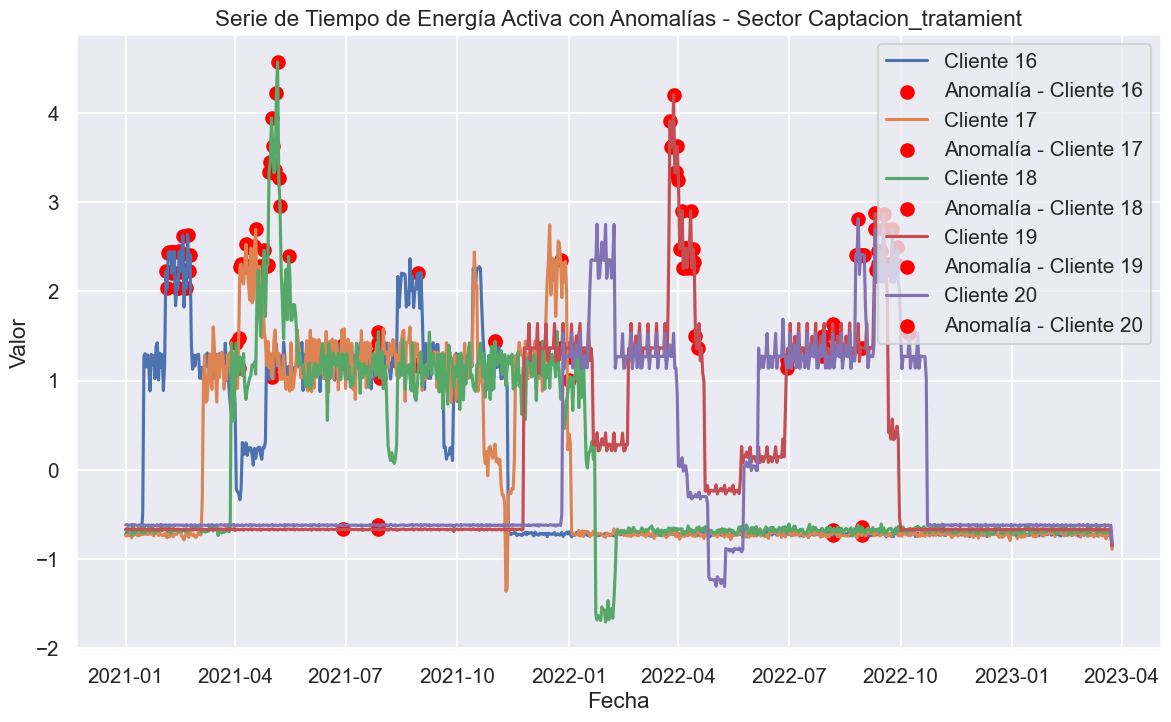

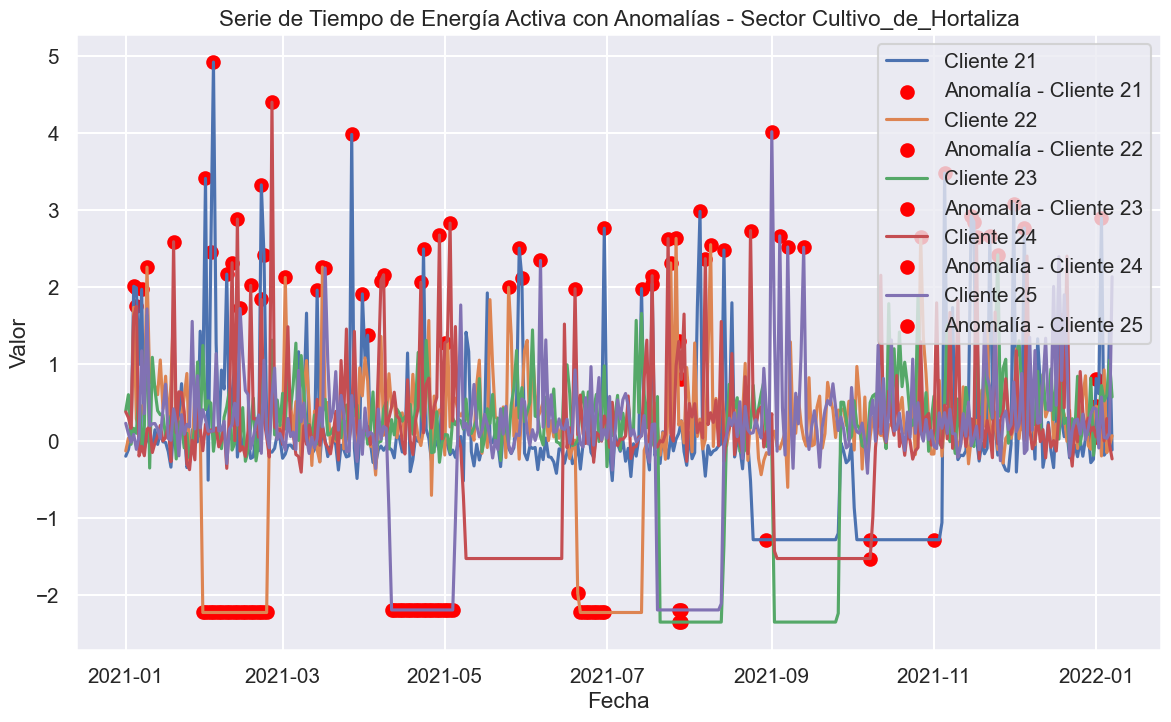

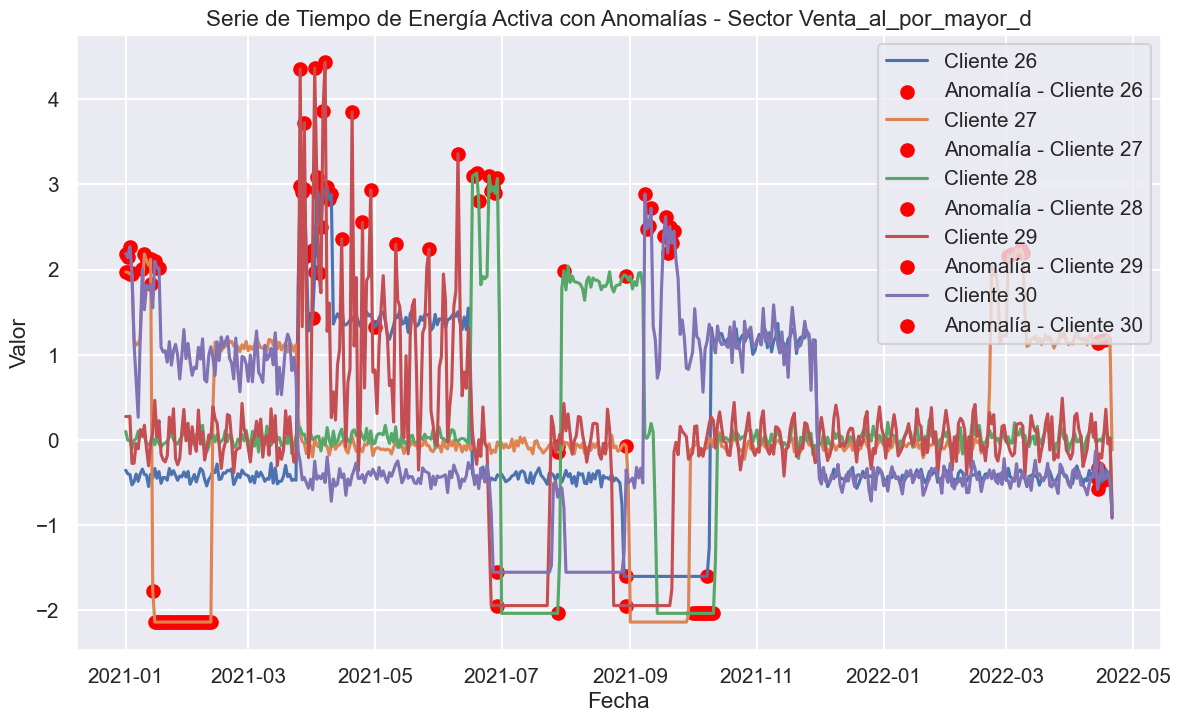

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_context('talk', font_scale=0.9)  # Puedes cambiar 'talk' por 'paper', 'notebook', 'talk', o 'poster'
y_pred_series = pd.Series(y_pred, name='y_pred')
X_scores_series = pd.Series(X_scores, name='X_scores')

# Unir las Series al DataFrame original
df_final = pd.concat([df.reset_index(drop=True), y_pred_series, X_scores_series], axis=1)

# Convertir la columna de índice de fechas a formato de fecha si aún no lo está
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

# Establecer la columna de fechas como el nuevo índice
df_final.set_index('Fecha', inplace=True)

# Obtener los identificadores únicos de los sectores
sectores_unicos = df_final['Sector'].unique()

# Crear una figura para cada sector
for sector in sectores_unicos:
    # Filtrar el DataFrame por sector
    df_sector = df_final[df_final['Sector'] == sector]
    
    # Crear una figura y un eje para este sector
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Obtener los identificadores únicos de los clientes dentro de este sector
    clientes_unicos = df_sector['id_Cliente'].unique().astype(int)
    
    # Graficar la serie de tiempo de 'Active_energy' para cada cliente en este sector
    for cliente in clientes_unicos:
        df_cliente = df_sector[df_sector['id_Cliente'] == cliente]
        sns.lineplot(data=df_cliente, x=df_cliente.index, y='Active_energy', ax=ax, label=f'Cliente {cliente}')
        
        # Resaltar las anomalías para este cliente
        anomalies = df_cliente[df_cliente['y_pred'] == -1]
        ax.scatter(anomalies.index, anomalies['Active_energy'], color='red', label=f'Anomalía - Cliente {cliente}')
        
        # Ajustar el tamaño de los puntos de anomalía basado en 'X_scores'
        sizes = (np.abs(anomalies['X_scores']) * 10).tolist()  # Ajusta el factor de escala según sea necesario
        for i, (index, point) in enumerate(anomalies.iterrows()):
            ax.scatter(index, point['Active_energy'], s=sizes[i], color='red')
    
    #plt.savefig(f'sector_{sector}.png')  # Guarda la imagen

    # Mejorar el gráfico para este sector
    ax.set_title(f'Serie de Tiempo de Energía Activa con Anomalías - Sector {sector}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor')
    ax.legend()
    #plt.savefig(f'sector_{sector}.png')  # Guarda la imagen
    # Mostrar el gráfico para este sector
    plt.show()

In [29]:


# Puntuaje de anomalías
anomaly_scores = lof.negative_outlier_factor_
# Predicción de anomalías
anomalies = lof.negative_outlier_factor_ < lof.offset_
lof_offset= lof.offset_


anomalies_series= pd.Series(anomalies, name='anomalies')
anomaly_scores_series = pd.Series(anomaly_scores, name='anomaly_scores')

y_pred_series = pd.Series(y_pred, name='y_pred')
X_scores_series = pd.Series(X_scores, name='X_scores')

lof_offset_series= pd.Series(lof_offset, name='lof_offset')
# Unir las Series al DataFrame original
df_final = pd.concat([df.reset_index(), y_pred_series, X_scores_series,anomalies_series, anomaly_scores_series], axis=1)

df_final['anomalies'] = np.where(df_final['y_pred'] == -1, True, False)

In [30]:
df_final

index  id_Cliente      Fecha  Active_energy  Reactive_energy  \
0          0           1 2021-01-01      -0.487280        -0.476663   
1          1           1 2021-01-02      -0.281029        -0.280404   
2          2           1 2021-01-03      -0.341933        -0.243627   
3          3           1 2021-01-04      -0.290769        -0.225733   
4          4           1 2021-01-05      -0.396625        -0.301140   
...      ...         ...        ...            ...              ...   
19322  19322           9 2023-03-28      -0.437393        -0.362789   
19323  19323           9 2023-03-29      -0.429171        -0.386516   
19324  19324           9 2023-03-30      -0.470403        -0.386100   
19325  19325           9 2023-03-31      -0.485132        -0.373260   
19326  19326           9 2023-04-01      -0.861175        -0.944042   

       Voltaje_FA  Voltaje_FC  Dia  Mes   Año  Trimestre Dia_semana  \
0       -0.307967   -0.311149    1    1  2021          1    Viernes   
1       -0.142477   -0.227722    2    1  2021          1     Sábado   
2       -0.191899    0.035979    3    1  2021          1    Domingo   
3       -0.216948   -0.072307    4    1  2021          1      Lunes   
4       -0.195798   -0.302537    5    1  2021          1     Martes   
...           ...         ...  ...  ...   ...        ...        ...   
19322   -0.247498   -0.247493   28    3  2023          1     Martes   
19323   -0.074941   -0.110032   29    3  2023          1  Miércoles   
19324   -0.115750   -0.053089   30    3  2023          1     Jueves   
19325   -0.078783   -0.082638   31    3  2023          1    Viernes   
19326   -1.248168   -1.263004    1    4  2023          2     Sábado   

       Es_festivo                Sector  y_pred  X_scores  anomalies  \
0               1  Elaboracion_de_cacao       1 -1.011909      False   
1               0  Elaboracion_de_cacao       1 -0.976822      False   
2               0  Elaboracion_de_cacao       1 -0.976308      False   
3               0  Elaboracion_de_cacao       1 -0.982615      False   
4               0  Elaboracion_de_cacao       1 -0.982777      False   
...           ...                   ...     ...       ...        ...   
19322           0  Cultivo_de_arboles_F       1 -1.007433      False   
19323           0  Cultivo_de_arboles_F       1 -1.009257      False   
19324           0  Cultivo_de_arboles_F       1 -1.006858      False   
19325           0  Cultivo_de_arboles_F       1 -1.009919      False   
19326           0  Cultivo_de_arboles_F       1 -1.012045      False   

       anomaly_scores  
0           -1.011909  
1           -0.976822  
2           -0.976308  
3           -0.982615  
4           -0.982777  
...               ...  
19322       -1.007433  
19323       -1.009257  
19324       -1.006858  
19325       -1.009919  
19326       -1.012045  

[19327 rows x 18 columns]

In [31]:
import pandas as pd

# Suponiendo que 'df_final' es tu DataFrame y ya contiene la columna 'anomalies'
# y 'y_pred' donde -1 indica una anomalía detectada por LOF

# Identificar valores atípicos en el campo 'Active_energy'
Q1 = df_final['Active_energy'].quantile(0.25)
Q3 = df_final['Active_energy'].quantile(0.75)
IQR = Q3 - Q1
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR

# Crear una nueva columna 'outlier' para identificar los valores atípicos
df_final['outlier'] = ((df_final['Active_energy'] < umbral_inferior) | (df_final['Active_energy'] > umbral_superior))

# Crear la matriz de referencia cruzada
matriz_referencia = pd.crosstab(df_final['outlier'], df_final['anomalies'])

# Calcular la precisión
TP = matriz_referencia.loc[True, True]  # Verdaderos Positivos
FP = matriz_referencia.loc[False, True]  # Falsos Positivos
precision = TP / (TP + FP)

print('Matriz de referencia cruzada:\n', matriz_referencia)
print('Precisión:', precision)


Matriz de referencia cruzada:
 anomalies  False  True 
outlier                
False      18258    532
True         102    435
Precisión: 0.4498448810754912


In [33]:
import pandas as pd

# Suponiendo que 'df_final' es tu DataFrame y ya contiene la columna 'anomalies'
# y 'y_pred' donde -1 indica una anomalía detectada por LOF

# Agrupar por 'Sector' y calcular los valores atípicos para cada sector
for sector in df_final['Sector'].unique():
    df_sector = df_final[df_final['Sector'] == sector]
    
    # Identificar valores atípicos en el campo 'Active_energy' para cada sector
    Q1 = df_sector['Active_energy'].quantile(0.25)
    Q3 = df_sector['Active_energy'].quantile(0.75)
    IQR = Q3 - Q1
    umbral_inferior = Q1 - 1.5 * IQR
    umbral_superior = Q3 + 1.5 * IQR
    
    # Crear una nueva columna 'outlier' para identificar los valores atípicos
    df_sector['outlier'] = ((df_sector['Active_energy'] < umbral_inferior) | (df_sector['Active_energy'] > umbral_superior))
    
    # Crear la matriz de referencia cruzada para cada sector
    matriz_referencia = pd.crosstab(df_sector['outlier'], df_sector['anomalies'])
    
    # Calcular la precisión para cada sector
    TP = matriz_referencia.loc[True, True]  # Verdaderos Positivos
    FP = matriz_referencia.loc[False, True]  # Falsos Positivos
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    print(f'Sector: {sector}')
    print('Matriz de referencia cruzada:\n', matriz_referencia)
    print('Precisión:', precision)
    print('--------------------------------------')


Sector: Elaboracion_de_cacao
Matriz de referencia cruzada:
 anomalies  False  True 
outlier                
False       2955      1
True         968    181
Precisión: 0.9945054945054945
--------------------------------------
Sector: Cultivo_de_arboles_F
Matriz de referencia cruzada:
 anomalies  False  True 
outlier                
False       3799     44
True         111    151
Precisión: 0.7743589743589744
--------------------------------------
Sector: Cultivo_de_otros_fru
Matriz de referencia cruzada:
 anomalies  False  True 
outlier                
False       2117     95
True           0     16
Precisión: 0.14414414414414414
--------------------------------------
Sector: Cultivo_de_hortaliza
Matriz de referencia cruzada:
 anomalies  False  True 
outlier                
False        506     58
True           6     14
Precisión: 0.19444444444444445
--------------------------------------
Sector: Captacion_tratamient
Matriz de referencia cruzada:
 anomalies  False  True 
outlier       

C:\Users\dmtor\AppData\Local\Temp\ipykernel_21660\1289892285.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sector['outlier'] = ((df_sector['Active_energy'] < umbral_inferior) | (df_sector['Active_energy'] > umbral_superior))
C:\Users\dmtor\AppData\Local\Temp\ipykernel_21660\1289892285.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sector['outlier'] = ((df_sector['Active_energy'] < umbral_inferior) | (df_sector['Active_energy'] > umbral_superior))
C:\Users\dmtor\AppData\Local\Temp\ipykerne